In [102]:
# Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# Import dos dados

In [103]:
url = 'https://github.com/AndersonCSM/DIO_aws-sagemaker-canvas-estoque/raw/main/datasets/dataset-1000-com-preco-promocional-e-renovacao-estoque.csv'

dataset = pd.read_csv(url)

In [104]:
dataset.head(5)  # Visualizando os dados

,ID_PRODUTO,DATA_EVENTO,PRECO,FLAG_PROMOCAO,QUANTIDADE_ESTOQUE
0,1000,2023-12-31,138.43,1,100
1,1001,2023-12-31,75.08,0,100
2,1002,2023-12-31,58.84,0,100
3,1003,2023-12-31,61.96,0,100
4,1004,2023-12-31,20.34,0,100


# Tratamento dos dados

In [105]:
dt = dataset.copy()  # Criando um backup do dataset

In [106]:
dt.info()  # Visualizando od dados | DATA_EVENTO não foi tipado corretamente

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_PRODUTO          1000 non-null   int64  
 1   DATA_EVENTO         1000 non-null   object 
 2   PRECO               1000 non-null   float64
 3   FLAG_PROMOCAO       1000 non-null   int64  
 4   QUANTIDADE_ESTOQUE  1000 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 39.2+ KB


In [107]:
# Tipando corretamente a coluna DATA_EVENTO
dt.DATA_EVENTO = pd.to_datetime(dt.DATA_EVENTO)

In [108]:
id_unicos = dt.ID_PRODUTO.unique()  # Extraindo os id's únicos dos produtos
id_unicos

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024])

# Análise Exploratória

In [109]:
# Verificando se o estoque é reposto
dt[(dt["ID_PRODUTO"] == 1001) & (dt["QUANTIDADE_ESTOQUE"]
                                 == dt["QUANTIDADE_ESTOQUE"].max())].value_counts()

# A reposição é feita em uma média de:


ID_PRODUTO  DATA_EVENTO  PRECO  FLAG_PROMOCAO  QUANTIDADE_ESTOQUE
1001        2023-12-31   75.08  0              100                   1
            2024-01-08   75.08  0              100                   1
            2024-01-18   75.08  0              100                   1
            2024-01-28   75.08  0              100                   1
Name: count, dtype: int64

In [110]:
rep1 = (31 - 8)
rep2 = (18 - 8)
rep3 = (28 - 18)
reposicao = round((rep1 + rep2 + rep3)/3)
reposicao

14

In [111]:
# função para retornar os dados de um produto diretamente
def get_data(dataset, product_id):
    return dataset[dataset['ID_PRODUTO'] == product_id]

In [112]:
# Gera plot de um produto especifíco
def plot(dataset, id_product):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    product_data = get_data(dataset, id_product)

    ax.scatter(product_data['DATA_EVENTO'], product_data['QUANTIDADE_ESTOQUE'])
    ax.set_ylabel(f"Contagem do produto {id_product}")
    ax.set_xlabel("Tempo")
    ax.set_title(f"Produto {id_product}")
    ax.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

In [113]:
# Gerar um plot de todos os produtos
def graphics(dt, id_products):
    fig, axes = plt.subplots(25, 2, figsize=(20, 100))

    for i in range(25):
        id_product = id_products[i]

        product_data = dt[dt['ID_PRODUTO'] == id_product]

        for j in range(2):
            ax = axes[i, j]

            ax.scatter(product_data['DATA_EVENTO'],
                       product_data['QUANTIDADE_ESTOQUE'])
            ax.set_ylabel(f"Contagem do produto {id_product}")
            ax.set_xlabel("Tempo")
            ax.set_title(f"Produto {id_product}")
            ax.grid(alpha=0.5)

    # Ajustar layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

In [114]:
# Transformando as variáveis em variáveis ficticias
use_dt = pd.get_dummies(dt, drop_first=True)

In [140]:
df = get_data(dt, 1001)
df.head()

,ID_PRODUTO,DATA_EVENTO,PRECO,FLAG_PROMOCAO,QUANTIDADE_ESTOQUE
1,1001,2023-12-31,75.08,0,100
26,1001,2024-01-01,67.57,1,88
51,1001,2024-01-02,75.08,0,81
76,1001,2024-01-03,75.08,0,72
101,1001,2024-01-04,75.08,0,54


In [141]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [143]:

# Selecionando as colunas de interesse
df = df[['PRECO', 'FLAG_PROMOCAO', 'QUANTIDADE_ESTOQUE']]

# Criando variáveis defasadas para capturar a dependência temporal
lags = 3  # Número de defasagens a serem incluídas
for col in ['PRECO', 'FLAG_PROMOCAO', 'QUANTIDADE_ESTOQUE']:
    for lag in range(1, lags + 1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Removendo as linhas com valores NaN resultantes das defasagens
df.dropna(inplace=True)

C:\Users\Windows10\AppData\Local\Temp\ipykernel_9112\1624414525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
C:\Users\Windows10\AppData\Local\Temp\ipykernel_9112\1624414525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
C:\Users\Windows10\AppData\Local\Temp\ipykernel_9112\1624414525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [148]:
df.shape

37 * 0.8

29.6

In [149]:
# Dividindo os dados em treino e teste
train_data = df.iloc[:30]
test_data = df.iloc[30:]

In [150]:
test_data

,PRECO,FLAG_PROMOCAO,QUANTIDADE_ESTOQUE,PRECO_lag1,PRECO_lag2,PRECO_lag3,FLAG_PROMOCAO_lag1,FLAG_PROMOCAO_lag2,FLAG_PROMOCAO_lag3,QUANTIDADE_ESTOQUE_lag1,QUANTIDADE_ESTOQUE_lag2,QUANTIDADE_ESTOQUE_lag3
826,67.57,1,75,75.08,75.08,75.08,0.0,0.0,0.0,76.0,85.0,95.0
851,75.08,0,69,67.57,75.08,75.08,1.0,0.0,0.0,75.0,76.0,85.0
876,75.08,0,67,75.08,67.57,75.08,0.0,1.0,0.0,69.0,75.0,76.0
901,75.08,0,65,75.08,75.08,67.57,0.0,0.0,1.0,67.0,69.0,75.0
926,75.08,0,64,75.08,75.08,75.08,0.0,0.0,0.0,65.0,67.0,69.0
951,75.08,0,46,75.08,75.08,75.08,0.0,0.0,0.0,64.0,65.0,67.0
976,75.08,0,37,75.08,75.08,75.08,0.0,0.0,0.0,46.0,64.0,65.0


In [151]:

# Separando as variáveis independentes e dependentes
X_train = train_data.drop(['PRECO'], axis=1)
y_train = train_data['PRECO']
X_test = test_data.drop(['PRECO'], axis=1)
y_test = test_data['PRECO']


Mean Squared Error (MSE): 3.0725005314208093e-26
R-squared (R2): 1.0


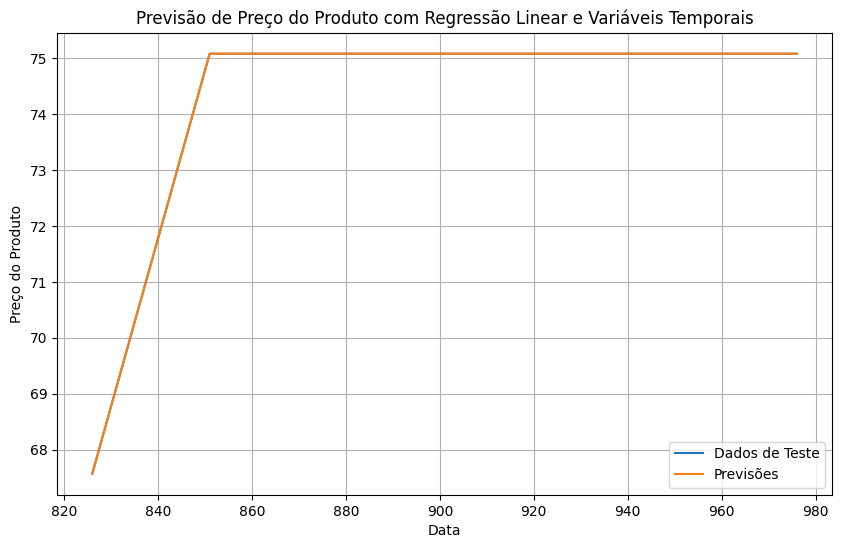

In [152]:

# Criando o modelo de regressão linear
model = LinearRegression()

# Treinando o modelo com os dados de treino
model.fit(X_train, y_train)

# Prevendo os valores de preço com os dados de teste
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Dados de Teste')
plt.plot(test_data.index, y_pred, label='Previsões')
plt.title('Previsão de Preço do Produto com Regressão Linear e Variáveis Temporais')
plt.xlabel('Data')
plt.ylabel('Preço do Produto')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
# Definir data como índice
df.set_index('DATA_EVENTO', inplace=True)
df = df[["QUANTIDADE_ESTOQUE"]]

KeyError: "None of [Index(['DATA_EVENTO'], dtype='object')] are in the [columns]"

In [116]:
# Dividindo os dados em treino e teste
train_data = df.iloc[:90]
test_data = df.iloc[90:]


In [121]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 1 to 976
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_PRODUTO          40 non-null     int64         
 1   DATA_EVENTO         40 non-null     datetime64[ns]
 2   PRECO               40 non-null     float64       
 3   FLAG_PROMOCAO       40 non-null     int64         
 4   QUANTIDADE_ESTOQUE  40 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.9 KB


In [119]:
r = int(reposicao)
# Aplicando o modelo SARIMA
order = (1, 1, 1)  # parâmetros p, d, q do modelo ARIMA
seasonal_order = (1, 1, 0, r)  # parâmetros P, D, Q, S do componente sazonal


In [120]:
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# Fazendo previsões
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')

# Avaliando o modelo
mse = mean_squared_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

In [ ]:

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['PRECO'], label='Dados de Treino')
plt.plot(test_data.index, test_data['PRECO'], label='Dados de Teste')
plt.plot(test_data.index, predictions, label='Previsões SARIMA')
plt.title('Previsão de Preço do Produto usando SARIMA')
plt.xlabel('Data')
plt.ylabel('Preço do Produto')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\Windows10\Desktop\GithubProjects\DataScience\DIO_project-Predicao_e_insight\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Windows10\Desktop\GithubProjects\DataScience\DIO_project-Predicao_e_insight\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Windows10\Desktop\GithubProjects\DataScience\DIO_project-Predicao_e_insight\.conda\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


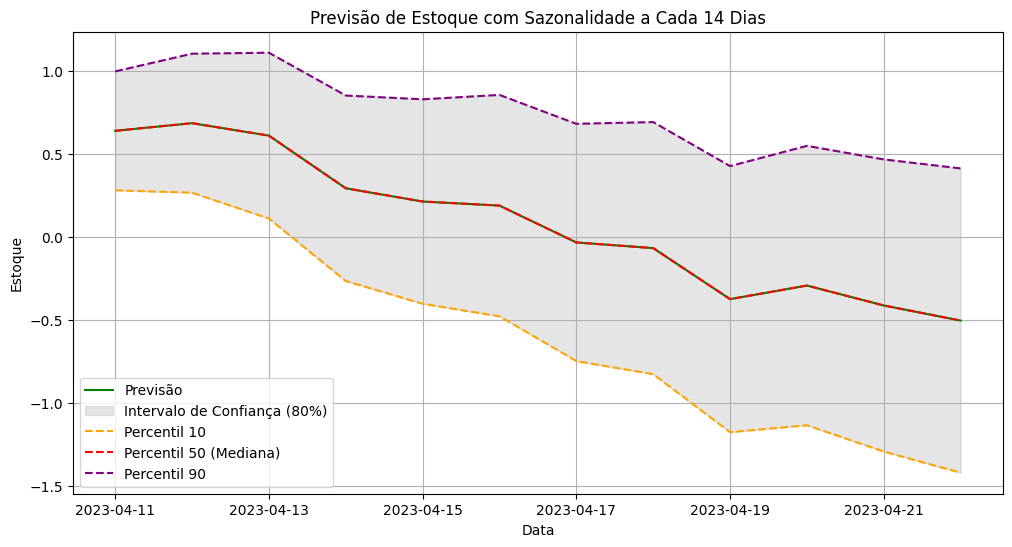

Erro médio quadrático no conjunto de teste: 0.8880980705074545


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Exemplo de dados fictícios periódicos a cada 14 dias
dates = pd.date_range('2023-01-01', periods=100, freq='D')
stock = np.sin(np.arange(100) * (2 * np.pi / 30)) + np.random.normal(0, 0.1, 100)

# Criar DataFrame
df = pd.DataFrame({'date': dates, 'stock': stock})

# Definir data como índice
df.set_index('date', inplace=True)

# Dividir em conjunto de treino e teste

# Ajustar modelo SARIMA com sazonalidade a cada 14 dias (S=14)
model = SARIMAX(df, order=(1, 1, 1), seasonal_order=(1, 1, 0, 14))
results = model.fit()

# Fazer previsões
forecast = results.get_forecast(steps=12, alpha=0.1)  # alpha=0.1 para percentis 10 e 90
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.1)  # intervalos de confiança para percentis 10 e 90

# Calcular percentis
forecast_percentile_10 = forecast_ci.iloc[:, 0]
forecast_percentile_50 = forecast_mean
forecast_percentile_90 = forecast_ci.iloc[:, 1]

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(forecast_mean.index, forecast_mean.values, label='Previsão', color='green')
plt.fill_between(forecast_ci.index, forecast_percentile_10, forecast_percentile_90, color='gray', alpha=0.2, label='Intervalo de Confiança (80%)')

plt.plot(forecast_mean.index, forecast_percentile_10, linestyle='--', color='orange', label='Percentil 10')
plt.plot(forecast_mean.index, forecast_percentile_50, linestyle='--', color='red', label='Percentil 50 (Mediana)')
plt.plot(forecast_mean.index, forecast_percentile_90, linestyle='--', color='purple', label='Percentil 90')

plt.title('Previsão de Estoque com Sazonalidade a Cada 14 Dias')
plt.xlabel('Data')
plt.ylabel('Estoque')
plt.legend()
plt.grid(True)
plt.show()

# Avaliar desempenho no conjunto de teste
predictions = forecast.predicted_mean
mse = mean_squared_error(test['stock'], predictions)
print(f"Erro médio quadrático no conjunto de teste: {mse}")


In [51]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [77]:
# Criar DataFrame
df = get_data(dt, 1001)

In [70]:
# plt.plot(df.DATA_EVENTO, df.QUANTIDADE_ESTOQUE)

In [78]:
df.head()

,ID_PRODUTO,DATA_EVENTO,PRECO,FLAG_PROMOCAO,QUANTIDADE_ESTOQUE
1,1001,2023-12-31,75.08,0,100
26,1001,2024-01-01,67.57,1,88
51,1001,2024-01-02,75.08,0,81
76,1001,2024-01-03,75.08,0,72
101,1001,2024-01-04,75.08,0,54


In [80]:
import numpy as np

# Adicionar variáveis seno e cosseno para representar a sazonalidade
df['month'] = pd.to_datetime(df['DATA_EVENTO']).dt.day
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 365)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 365)

# Aplicar regressão linear incluindo as variáveis seno e cosseno
from sklearn.linear_model import LinearRegression

X = df[['sin_month', 'cos_month', 'FLAG_PROMOCAO']]
y = df['QUANTIDADE_ESTOQUE']

model = LinearRegression()
model.fit(X, y)


C:\Users\Windows10\AppData\Local\Temp\ipykernel_9112\3511423093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['DATA_EVENTO']).dt.day
C:\Users\Windows10\AppData\Local\Temp\ipykernel_9112\3511423093.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sin_month'] = np.sin(2 * np.pi * df['month'] / 365)
C:\Users\Windows10\AppData\Local\Temp\ipykernel_9112\3511423093.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

LinearRegression()

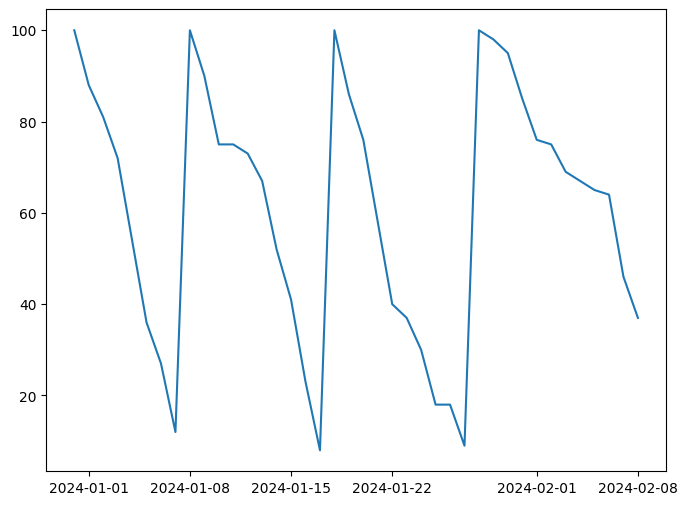

In [90]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df['DATA_EVENTO'], df['QUANTIDADE_ESTOQUE'])

plt.show()

In [93]:
seasonality = df[df["QUANTIDADE_ESTOQUE"] == df["QUANTIDADE_ESTOQUE"].max()]
seasonality

,ID_PRODUTO,DATA_EVENTO,PRECO,FLAG_PROMOCAO,QUANTIDADE_ESTOQUE,month,sin_month,cos_month
1,1001,2023-12-31,75.08,0,100,31,0.508671,0.860961
201,1001,2024-01-08,75.08,0,100,8,0.137279,0.990532
451,1001,2024-01-18,75.08,0,100,18,0.304921,0.952378
701,1001,2024-01-28,75.08,0,100,28,0.463550,0.886071


# Modelos


# Avaliação dos Modelos

# Visualização